<a href="https://colab.research.google.com/github/nikhil-xyz/Agentic-AI/blob/main/Langgraph_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install langchain-community langgraph typing typing_extensions arxiv wikipedia langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 4.6 MB/s eta 0:00:00


In [96]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [97]:
arxiv_api = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=400)
arxiv = ArxivQueryRun(api_wrapper = arxiv_api)

In [98]:
wiki_api = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=400)
wikipedia = WikipediaQueryRun(api_wrapper = wiki_api)

In [99]:
from google.colab import userdata
tavily_api_key = userdata.get('TAVILY_API_KEY')

In [100]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults(tavily_api_key = tavily_api_key)

In [101]:
tools = [wikipedia, tavily, arxiv]

In [102]:
from google.colab import userdata
groq_api_key = userdata.get('GROQ_API_KEY')

In [103]:
from langchain_groq import ChatGroq
llm = ChatGroq(model='qwen-qwq-32b', groq_api_key=groq_api_key)

In [104]:
tool_llm = llm.bind_tools(tools=tools)

In [105]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages

In [106]:
class State(TypedDict):
  messages : Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [107]:
class LLMNode:
  def __init__(self, llm):
    self.llm = llm

  def __call__(self, state: State):
    return {'messages' : self.llm.invoke(state['messages'])}

llm_node = LLMNode(tool_llm)

In [108]:
tool_node = ToolNode(tools)

In [109]:
graph_builder.add_node("llm", llm_node)
graph_builder.add_node("tools", tool_node)

In [110]:
graph_builder.add_edge(START, "llm")
graph_builder.add_conditional_edges("llm", tools_condition)
graph_builder.add_edge("tools", "llm")

agent = graph_builder.compile()

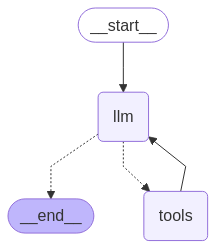

In [113]:
from IPython.display import display, Image
display(Image(agent.get_graph().draw_mermaid_png()))

In [116]:
result = agent.invoke({'messages' : "Tell me about the recent GDP figures of the US?"})

In [120]:
result['messages'][3].content

"The most recent U.S. GDP figures show that the economy contracted at an annualized rate of **0.3%** in the first quarter of 2025 (Q1 2025), according to the U.S. Bureau of Economic Analysis (BEA) advance estimate released in April 2025. This marked a slowdown compared to the **2.4% growth** in the fourth quarter of 2024. \n\n### Key Details:\n1. **Quarterly Performance**:  \n   - The Q1 2025 contraction (advance estimate) was driven by factors like reduced private inventory investment and slower government spending, partially offset by strong consumer spending and business investment.  \n   - The BEA noted this was the first quarterly decline since early 2022.  \n\n2. **Context**:  \n   - The Federal Reserve reported nominal GDP reached **$29.98 trillion** in Q1 2025 (seasonally adjusted annual rate).  \n   - Analysts attributed the slowdown to businesses stockpiling goods ahead of anticipated tariff policies, which may have pulled demand forward into late 2024.  \n\n3. **Forecasts vs